# Amazon Bedrock Batch Inference

## 情報
### 公開情報
- 開発者ドキュメント: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference.html
- Quota: https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#quotas-batch
- コードサンプル: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-example.html

### 2024.1.25
- Public Preview
- 利用方法
    - REST API: あると思うが面倒
    - CLI: 無さそう
    - SDK: プレビューのがある
        - PythonとJavaのみ
        - https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip
    - コンソール: 無さそう

## 背景
- Bedrockのbatch推論のquotaがon demandと関係ない（だからquotaに引っ掛からなくてうれしい）と言う説
- text to image (SDXL or Titan or Both)で500枚くらいバッチ推論ジョブを発行してどんな風に実行が完了するか（もしくは完了しないか）を見てみる
- On demandのquotaより明らかに早かったら嬉しい


## 検証条件
- 推論方式: バッチ
- 生成: テキストから画像
- モデル: amazon.titan-image-generator-v1 & stability.stable-diffusion-xl-v1

## 単発推論

まずは単発を確認

サンプルコード: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#model-parameters-titan-image-code-examples

INFO:__main__:Generating image with Titan Image Generator G1 model amazon.titan-image-generator-v1
INFO:__main__:Successfully generated image with Titan Image Generator G1 model amazon.titan-image-generator-v1


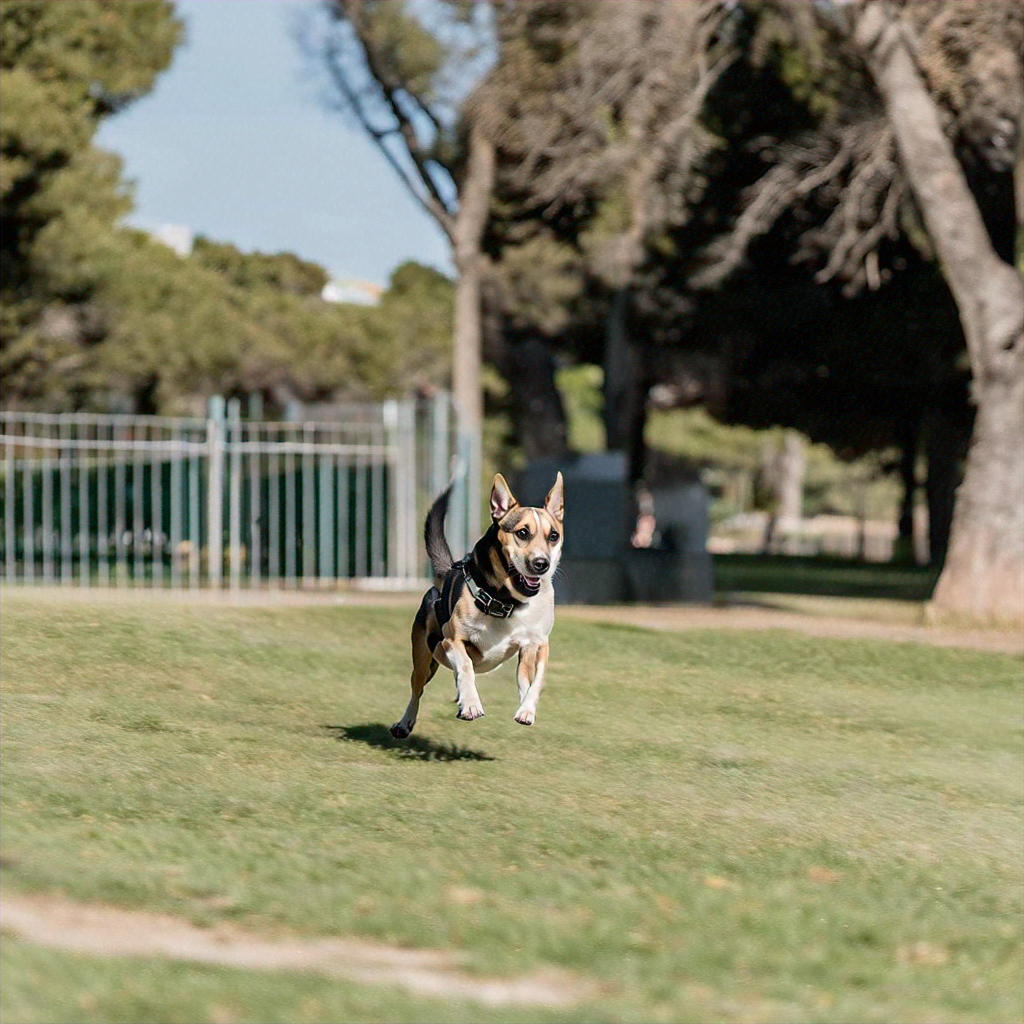

Finished generating image with Titan Image Generator G1 model amazon.titan-image-generator-v1.


In [26]:
import base64
import io
import json
import logging
import boto3
from PIL import Image
from botocore.exceptions import ClientError


class ImageError(Exception):
    "Custom exception for errors returned by Titan Image Generator G1"
    def __init__(self, message):
        self.message = message


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


def generate_image(model_id, body):
    """
    Generate an image using Titan Image Generator G1 model on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    logger.info("Generating image with Titan Image Generator G1 model %s", model_id)

    bedrock = boto3.client(service_name='bedrock-runtime')
    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body = body,
        modelId = model_id,
        accept = accept,
        contentType = content_type
    )
    response_body = json.loads(response.get("body").read())

    base64_image = response_body.get("images")[0]
    base64_bytes = base64_image.encode('ascii')
    image_bytes = base64.b64decode(base64_bytes)

    finish_reason = response_body.get("error")

    if finish_reason is not None:
        raise ImageError(f"Image generation error. Error is {finish_reason}")

    logger.info("Successfully generated image with Titan Image Generator G1 model %s", model_id)

    return image_bytes


def main():
    """
    Entrypoint for Titan Image Generator G1 example.
    """

    logging.basicConfig(
        level = logging.INFO,
        format = "%(levelname)s: %(message)s"
    )

    model_id = 'amazon.titan-image-generator-v1'
    prompt = """A dog running at a park."""

    body = json.dumps({
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "standard",
            "height": 1024,
            "width": 1024,
            "cfgScale": 8.0,
            "seed": 0
        }
    })

    try:
        image_bytes = generate_image(
            model_id = model_id,
            body = body
        )
        image = Image.open(io.BytesIO(image_bytes))
        image.show()

    except ClientError as err:
        message = err.response["Error"]["Message"]
        logger.error("A client error occurred: %s", message)
        print("A client error occured: " + format(message))
    except ImageError as err:
        logger.error(err.message)
        print(err.message)

    else:
        print(f"Finished generating image with Titan Image Generator G1 model {model_id}.")


if __name__ == "__main__":
    main()

## 検証

### 環境準備

In [1]:
! wget https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip

--2024-01-25 00:47:13--  https://d2eo22ngex1n9g.cloudfront.net/Documentation/SDK/bedrock-python-sdk-reinvent.zip
Resolving d2eo22ngex1n9g.cloudfront.net (d2eo22ngex1n9g.cloudfront.net)... 99.84.216.107, 99.84.216.166, 99.84.216.85, ...
Connecting to d2eo22ngex1n9g.cloudfront.net (d2eo22ngex1n9g.cloudfront.net)|99.84.216.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314169135 (300M) [application/zip]
Saving to: ‘bedrock-python-sdk-reinvent.zip’

bedrock-python-sdk- 100%[===================>] 299.61M  35.6MB/s    in 7.3s    

2024-01-25 00:47:21 (40.8 MB/s) - ‘bedrock-python-sdk-reinvent.zip’ saved [314169135/314169135]



In [33]:
SDK = "sdk"

! unzip -f -d $SDK bedrock-python-sdk-reinvent.zip
! ls $SDK

env: SDK=sdk
Archive:  bedrock-python-sdk-reinvent.zip
AWSCLI32.msi			boto3-1.29.4-py3-none-any.whl
AWSCLI32PY3.msi			boto3-1.29.4.tar.gz
AWSCLI64.msi			botocore-1.32.4-py3-none-any.whl
AWSCLI64PY3.msi			botocore-1.32.4.tar.gz
AWSCLISetup.exe			manifest.json
awscli-1.30.4-py3-none-any.whl	models-starfort-report.json
awscli-1.30.4.tar.gz		reviews
awscli-bundle.zip


下記より、以下を参照: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-example.html

In [39]:
! find $SDK -type f -name boto*.whl

sdk/botocore-1.32.4-py3-none-any.whl
sdk/boto3-1.29.4-py3-none-any.whl


In [38]:
! pip install $SDK/botocore-1.32.4-py3-none-any.whl
! pip install $SDK/boto3-1.29.4-py3-none-any.whl

Processing ./sdk/botocore-1.32.4-py3-none-any.whl
botocore is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing ./sdk/boto3-1.29.4-py3-none-any.whl
boto3 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [6]:
! aws --version

aws-cli/1.22.34 Python/3.10.12 Linux/4.14.330-250.540.amzn2.x86_64 botocore/1.23.34


### 入力データフォーマット
参考: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-data.html

以下、サンプルの入力JSON

入力JSON Linesフォーマット
```JSON
{
    "recordId": "12 character alphanumeric string", # recordIdフィールドを外すと、Amazon Bedrockが出力に追加
    "modelInput": {JSON body}
}
...
{
    "recordId": "12 character alphanumeric string", # recordIdフィールドを外すと、Amazon Bedrockが出力に追加
    "modelInput": {JSON body}
}
```

Titanの場合の推論入力JSON: https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html#model-parameters-titan-request-body

```JSON
{
    "inputText": string,
    "textGenerationConfig": { // オプション
        "temperature": float,  
        "topP": float,
        "maxTokenCount": int,
        "stopSequences": [string]
    }
}
```

Tiatanの場合のバッチ推論入力JSON Lines
```JSON
{
    "modelInput": {"inputText": string}
}
...
{
    "modelInput": {"inputText": string}
}
```

### 条件設定

In [14]:
model_id = "amazon.titan-image-generator-v1"
# model_id = "stability.stable-diffusion-xl-v1"

prompt = "A dog running at a park."
number_of_images = 500
jsonl_path = "input/input.jsonl"

### 環境設定

In [15]:
from yaml import safe_load
with open("config.yaml", "r") as config_file:
    config = safe_load(config_file)

role = config.get("role")
s3_path = config.get("s3_path")

### バッチ用入力データ出力

In [16]:
input_json = {
    "modelInput": {
        "inputText": prompt
    }
}

from pandas import DataFrame

df = DataFrame([input_json for _ in range(number_of_images)])
df.to_json(jsonl_path, force_ascii=False, lines=True, orient='records')

import json
with open(jsonl_path) as jsonl_file:
    jsonl_content = jsonl_file.read()

jsonl_content

'{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a park"}}\n{"modelInput":{"inputText":"A dog running at a 

In [17]:
! ls -la $jsonl_path

-rw-r--r-- 1 sagemaker-user users 27500 Jan 26 01:01 input/input.jsonl


In [18]:
! aws s3 cp $jsonl_path $s3_path/input/  > /dev/null

### 推論

In [19]:
import boto3
bedrock = boto3.client(service_name="bedrock")

def get_job_status(job_arn:str):
    job = bedrock.get_model_invocation_job(jobIdentifier=job_arn)
    job_status = job.get("status")
    return job_status

In [20]:
inputDataConfig = ({
    "s3InputDataConfig": {
        "s3Uri": f"{s3_path}/{jsonl_path}"
    }
})

outputDataConfig=({
    "s3OutputDataConfig": {
        "s3Uri": f"{s3_path}/output/"
    }
})

from datetime import timezone, datetime, timedelta

now = datetime.now(timezone.utc)
time_delta = timedelta(hours = 9)
jst = timezone(time_delta)
formatted_time = now.astimezone(jst).strftime("%Y-%m-%d-%H-%M-%S")

job_name = f"{model_id}-{formatted_time}"
job_name

'stability.stable-diffusion-xl-v1-2024-01-26-10-01-47'

In [21]:
response = bedrock.create_model_invocation_job(
    roleArn = role,
    modelId = model_id,
    jobName = job_name,
    inputDataConfig = inputDataConfig,
    outputDataConfig = outputDataConfig
)
response

{'ResponseMetadata': {'RequestId': 'ea95f9cd-bce8-47ea-912e-9c65041d487b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 26 Jan 2024 01:01:49 GMT',
   'content-type': 'application/json',
   'content-length': '85',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ea95f9cd-bce8-47ea-912e-9c65041d487b'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-east-1:624045005200:model-invocation-job/ml3dc9fcsvtn'}

In [22]:
job_arn = response.get("jobArn")
job_id = job_arn.split("/")[-1]
job_id

'ml3dc9fcsvtn'

ジョブの状態はこちら: https://docs.aws.amazon.com/bedrock/latest/userguide/batch-inference-list.html

In [24]:
from time import sleep
job_status = get_job_status(job_arn)

while job_status in ("Submitted", "InProgress"):
    job_status = get_job_status(job_arn)
    print(job_status)
    ! aws s3 cp $s3_path/output/$job_id/manifest.json.out -
    sleep(10)

job_status

'Completed'

In [ ]:
# bedrock.list_model_invocation_jobs()